# Anime Recommendation System

Notebook này demo toàn bộ quy trình xây dựng hệ thống gợi ý anime từ đầu đến cuối:

1. **Load & Inspect Data** - Tải và khám phá dữ liệu
2. **Data Cleaning** - Làm sạch và tiền xử lý
3. **Exploratory Data Analysis** - Trực quan hóa với nhiều biểu đồ
4. **Train/Test Split** - Chia dữ liệu training và testing
5. **Model Training** - Huấn luyện các models (CF & Deep Learning)
6. **Model Evaluation** - Đánh giá và so sánh models
7. **Recommendation Demo** - Test và demo gợi ý phim

## 1. Setup & Import Libraries

In [1]:
# Data Processing
import pandas as pd
import numpy as np
from collections import defaultdict, Counter

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Database
from pymongo import MongoClient

# Custom modules
import sys
import os
sys.path.insert(0, './backend')

from ml.models.user_based import UserBasedCF
from ml.models.item_based import ItemBasedCF
from ml.models.hybrid import HybridWeightedCF
from ml.models.neural_cf import NeuralCF

# Utilities
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")

All libraries imported successfully!


## 2. Load Data from MongoDB

Tải dữ liệu ratings và anime từ MongoDB database.

In [2]:
# Connect to MongoDB
MONGODB_URI = 'mongodb://localhost:27017/'
MONGODB_DB = 'anime_recommendation'

client = MongoClient(MONGODB_URI)
db = client[MONGODB_DB]

print(f"Connected to MongoDB: {MONGODB_DB}")
print(f"Collections: {db.list_collection_names()}")

Connected to MongoDB: anime_recommendation
Collections: ['model_registry', 'ratings', 'watch_history', 'users', 'animes']


In [3]:
# Load ratings data
print("Loading ratings...")
ratings_cursor = db.ratings.find({}, {'_id': 0})
ratings_df = pd.DataFrame(list(ratings_cursor))

print(f"Loaded {len(ratings_df):,} ratings")
print(f"  - Unique users: {ratings_df['user_id'].nunique():,}")
print(f"  - Unique anime: {ratings_df['anime_id'].nunique():,}")

ratings_df.head()

Loading ratings...
Loaded 3,000,002 ratings
  - Unique users: 16,131
  - Unique anime: 14,636


,user_id,anime_id,rating,created_at,updated_at
0,0,430,9,NaT,NaT
1,0,1004,5,NaT,NaT
2,0,3010,7,NaT,NaT
3,0,570,7,NaT,NaT
4,0,2762,9,NaT,NaT


In [4]:
# Load anime data
print("Loading anime metadata...")
anime_cursor = db.animes.find({}, {'_id': 0})
anime_df = pd.DataFrame(list(anime_cursor))

print(f"Loaded {len(anime_df):,} anime")
anime_df.head()

Loading anime metadata...
Loaded 16,214 anime


,mal_id,name,score,genres,synopsis
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ..."
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,0..."
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",ches are individuals with special powers like ...
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",It is the dark century and the people are suff...


## 3. Data Inspection & Statistics

In [5]:
# Ratings statistics
print("=" * 60)
print("RATINGS STATISTICS")
print("=" * 60)

print(f"\nTotal ratings: {len(ratings_df):,}")
print(f"Rating range: {ratings_df['rating'].min()} - {ratings_df['rating'].max()}")
print(f"Average rating: {ratings_df['rating'].mean():.2f}")
print(f"Median rating: {ratings_df['rating'].median():.1f}")

print(f"\nSparsity: {100 * (1 - len(ratings_df) / (ratings_df['user_id'].nunique() * ratings_df['anime_id'].nunique())):.2f}%")

ratings_df.describe()

RATINGS STATISTICS

Total ratings: 3,000,002
Rating range: 1 - 10
Average rating: 7.51
Median rating: 8.0

Sparsity: 98.73%


,user_id,anime_id,rating,created_at,updated_at
count,3.000002e+06,3.000002e+06,3.000002e+06,2,2
mean,9.349842e+03,1.592139e+04,7.511457e+00,2025-12-05 12:32:02.239500032,2025-12-05 12:32:04.775000064
min,0.000000e+00,1.000000e+00,1.000000e+00,2025-12-05 09:42:14.534000,2025-12-05 09:42:14.534000
25%,4.944000e+03,3.229000e+03,7.000000e+00,2025-12-05 11:07:08.386750208,2025-12-05 11:07:09.654500096
50%,9.496000e+03,1.203100e+04,8.000000e+00,2025-12-05 12:32:02.239500032,2025-12-05 12:32:04.775000064
75%,1.384100e+04,2.909300e+04,9.000000e+00,2025-12-05 13:56:56.092249856,2025-12-05 13:56:59.895500032
max,1.845400e+04,4.845600e+04,1.000000e+01,2025-12-05 15:21:49.945000,2025-12-05 15:21:55.016000
std,5.284186e+03,1.327459e+04,1.691791e+00,NaN,NaN


In [6]:
# User statistics
user_stats = ratings_df.groupby('user_id').agg({
    'rating': ['count', 'mean', 'std']
}).reset_index()
user_stats.columns = ['user_id', 'num_ratings', 'avg_rating', 'std_rating']

print("User Statistics:")
print(f"  Min ratings per user: {user_stats['num_ratings'].min()}")
print(f"  Max ratings per user: {user_stats['num_ratings'].max()}")
print(f"  Avg ratings per user: {user_stats['num_ratings'].mean():.1f}")
print(f"  Median ratings per user: {user_stats['num_ratings'].median():.1f}")

user_stats.describe()

User Statistics:
  Min ratings per user: 1
  Max ratings per user: 8215
  Avg ratings per user: 186.0
  Median ratings per user: 112.0


,user_id,num_ratings,avg_rating,std_rating
count,16131.000000,16131.000000,16131.000000,15826.000000
mean,9231.250015,185.977435,7.933020,1.325512
std,5327.656568,255.293530,0.936822,0.467014
min,0.000000,1.000000,1.000000,0.000000
25%,4625.000000,43.000000,7.379895,1.059462
50%,9242.000000,112.000000,7.924242,1.297564
75%,13851.500000,238.000000,8.500000,1.573574
max,18454.000000,8215.000000,10.000000,6.363961


In [7]:
# Item (anime) statistics
item_stats = ratings_df.groupby('anime_id').agg({
    'rating': ['count', 'mean', 'std']
}).reset_index()
item_stats.columns = ['anime_id', 'num_ratings', 'avg_rating', 'std_rating']

print("Anime Statistics:")
print(f"  Min ratings per anime: {item_stats['num_ratings'].min()}")
print(f"  Max ratings per anime: {item_stats['num_ratings'].max()}")
print(f"  Avg ratings per anime: {item_stats['num_ratings'].mean():.1f}")
print(f"  Median ratings per anime: {item_stats['num_ratings'].median():.1f}")

item_stats.describe()

Anime Statistics:
  Min ratings per anime: 1
  Max ratings per anime: 9567
  Avg ratings per anime: 205.0
  Median ratings per anime: 22.0


,anime_id,num_ratings,avg_rating,std_rating
count,14636.000000,14636.000000,14636.000000,13338.000000
mean,19521.461807,204.974173,6.220586,1.571489
std,14780.279546,572.725526,1.325953,0.522214
min,1.000000,1.000000,1.000000,0.000000
25%,4559.500000,4.000000,5.500000,1.324887
50%,17829.000000,22.000000,6.437500,1.544807
75%,34422.250000,121.000000,7.137260,1.820933
max,48456.000000,9567.000000,10.000000,5.656854


## 4. Data Cleaning

In [8]:
print("Checking for missing values...")
print("\nRatings DataFrame:")
print(ratings_df.isnull().sum())

print("\nAnime DataFrame:")
print(anime_df.isnull().sum())

# Handle missing synopsis
anime_df['synopsis'] = anime_df['synopsis'].fillna('No synopsis available')
anime_df['genres'] = anime_df['genres'].fillna('Unknown')

print("\nMissing values handled")

Checking for missing values...

Ratings DataFrame:
user_id             0
anime_id            0
rating              0
created_at    3000000
updated_at    3000000
dtype: int64

Anime DataFrame:
mal_id      0
name        0
score       0
genres      0
synopsis    0
dtype: int64

Missing values handled


In [9]:
# Remove duplicates
print(f"Duplicates in ratings: {ratings_df.duplicated(['user_id', 'anime_id']).sum()}")
ratings_df = ratings_df.drop_duplicates(['user_id', 'anime_id'])

print(f"Duplicates in anime: {anime_df.duplicated(['mal_id']).sum()}")
anime_df = anime_df.drop_duplicates(['mal_id'])

print("\nDuplicates removed")

Duplicates in ratings: 0
Duplicates in anime: 0

Duplicates removed


In [10]:
# Filter out users/items with very few ratings (optional)
MIN_USER_RATINGS = 5
MIN_ANIME_RATINGS = 5

print(f"Filtering users with < {MIN_USER_RATINGS} ratings...")
user_counts = ratings_df['user_id'].value_counts()
valid_users = user_counts[user_counts >= MIN_USER_RATINGS].index
filtered_ratings = ratings_df[ratings_df['user_id'].isin(valid_users)]

print(f"Filtering anime with < {MIN_ANIME_RATINGS} ratings...")
anime_counts = filtered_ratings['anime_id'].value_counts()
valid_anime = anime_counts[anime_counts >= MIN_ANIME_RATINGS].index
filtered_ratings = filtered_ratings[filtered_ratings['anime_id'].isin(valid_anime)]

print(f"\nAfter filtering:")
print(f"  Ratings: {len(filtered_ratings):,} (removed {len(ratings_df) - len(filtered_ratings):,})")
print(f"  Users: {filtered_ratings['user_id'].nunique():,}")
print(f"  Anime: {filtered_ratings['anime_id'].nunique():,}")

# Use filtered data
ratings_clean = filtered_ratings.copy()
print("\nData cleaned successfully")

Filtering users with < 5 ratings...
Filtering anime with < 5 ratings...

After filtering:
  Ratings: 2,989,863 (removed 10,139)
  Users: 15,274
  Anime: 10,921

Data cleaned successfully


## 5. Exploratory Data Analysis (EDA)

Trực quan hóa dữ liệu với nhiều biểu đồ khác nhau.

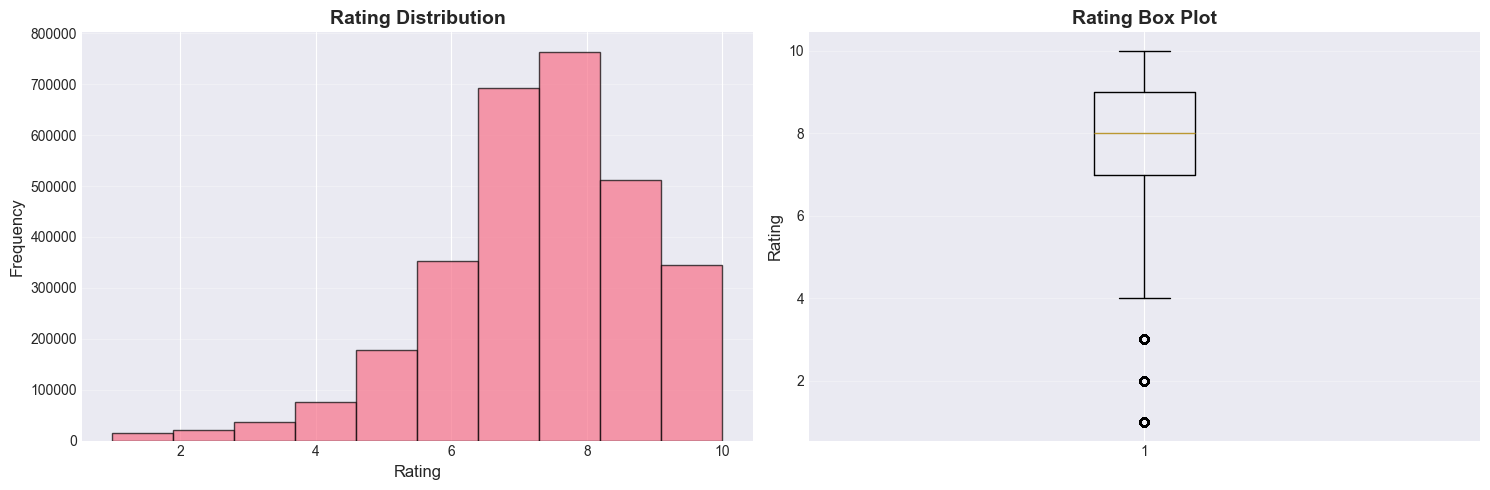

Rating Distribution:
rating
1      15333
2      20995
3      36520
4      75154
5     177243
6     352855
7     692260
8     763763
9     511063
10    344677
Name: count, dtype: int64


In [11]:
# 5.1 Rating Distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
axes[0].hist(ratings_clean['rating'], bins=10, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Rating', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Rating Distribution', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Box plot
axes[1].boxplot(ratings_clean['rating'], vert=True)
axes[1].set_ylabel('Rating', fontsize=12)
axes[1].set_title('Rating Box Plot', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Rating Distribution:")
print(ratings_clean['rating'].value_counts().sort_index())

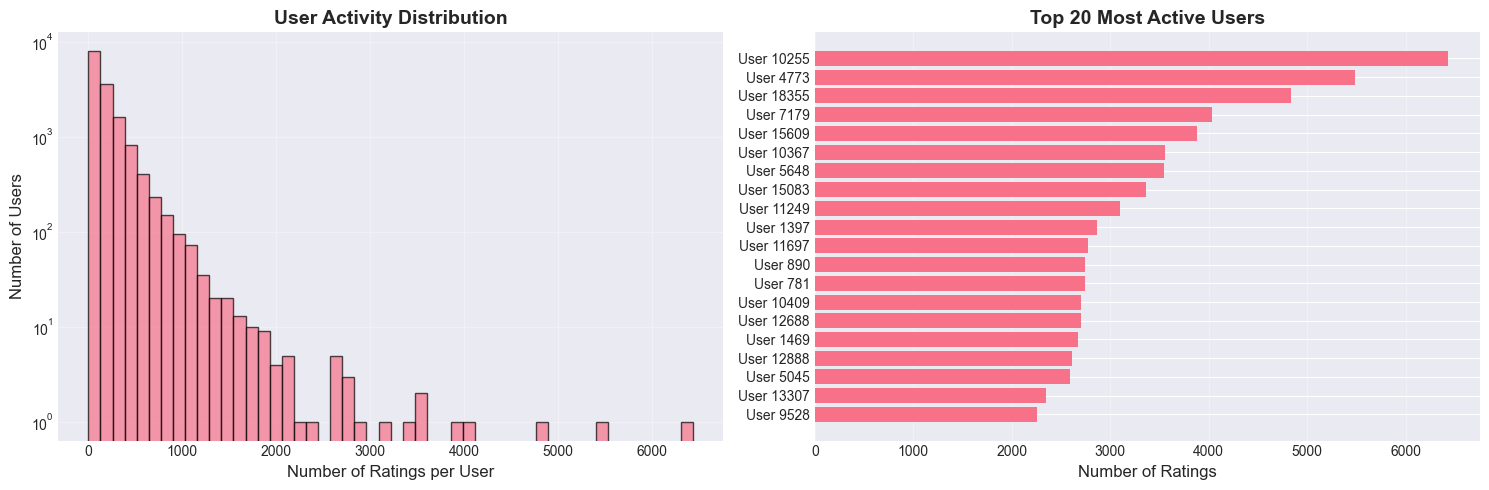

In [12]:
# 5.2 User Activity Distribution
user_activity = ratings_clean.groupby('user_id').size()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
axes[0].hist(user_activity, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Number of Ratings per User', fontsize=12)
axes[0].set_ylabel('Number of Users', fontsize=12)
axes[0].set_title('User Activity Distribution', fontsize=14, fontweight='bold')
axes[0].set_yscale('log')
axes[0].grid(alpha=0.3)

# Top 20 most active users
top_users = user_activity.nlargest(20)
axes[1].barh(range(len(top_users)), top_users.values)
axes[1].set_yticks(range(len(top_users)))
axes[1].set_yticklabels([f'User {uid}' for uid in top_users.index])
axes[1].set_xlabel('Number of Ratings', fontsize=12)
axes[1].set_title('Top 20 Most Active Users', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

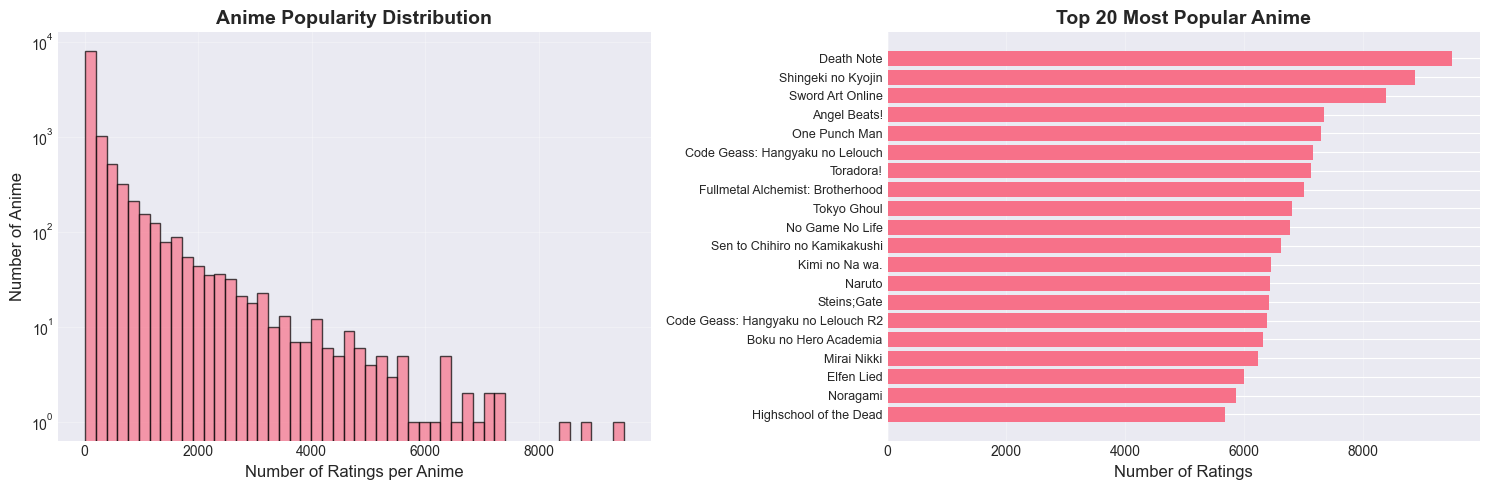

In [13]:
# 5.3 Anime Popularity Distribution
anime_popularity = ratings_clean.groupby('anime_id').size()

# Merge with anime names
popularity_df = pd.DataFrame({
    'anime_id': anime_popularity.index,
    'num_ratings': anime_popularity.values
})
popularity_df = popularity_df.merge(anime_df[['mal_id', 'name']], 
                                    left_on='anime_id', right_on='mal_id', how='left')

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

#  Histogram
axes[0].hist(anime_popularity, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Number of Ratings per Anime', fontsize=12)
axes[0].set_ylabel('Number of Anime', fontsize=12)
axes[0].set_title('Anime Popularity Distribution', fontsize=14, fontweight='bold')
axes[0].set_yscale('log')
axes[0].grid(alpha=0.3)

# Top 20 most popular anime
top_anime = popularity_df.nlargest(20, 'num_ratings')
axes[1].barh(range(len(top_anime)), top_anime['num_ratings'])
axes[1].set_yticks(range(len(top_anime)))
axes[1].set_yticklabels(top_anime['name'], fontsize=9)
axes[1].set_xlabel('Number of Ratings', fontsize=12)
axes[1].set_title('Top 20 Most Popular Anime', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

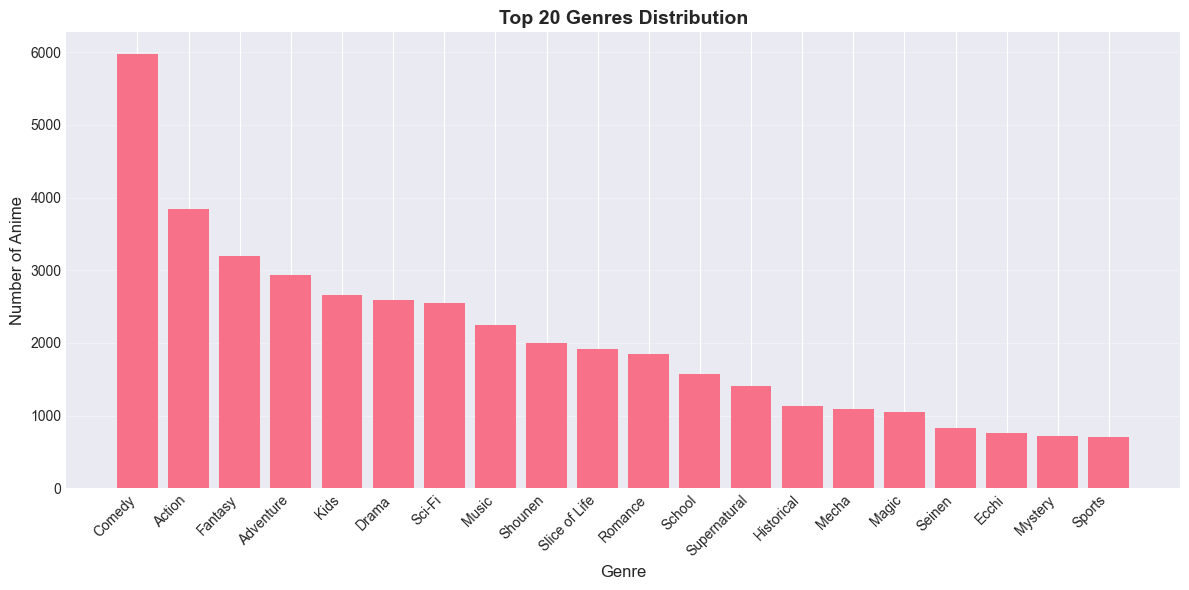

In [14]:
# 5.4 Genre Analysis
# Parse genres (comma-separated)
all_genres = []
for genres_str in anime_df['genres'].dropna():
    if isinstance(genres_str, str) and genres_str != 'Unknown':
        genres = [g.strip() for g in genres_str.split(',')]
        all_genres.extend(genres)

genre_counts = Counter(all_genres)
top_genres = dict(genre_counts.most_common(20))

plt.figure(figsize=(12, 6))
plt.bar(range(len(top_genres)), list(top_genres.values()))
plt.xticks(range(len(top_genres)), list(top_genres.keys()), rotation=45, ha='right')
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Number of Anime', fontsize=12)
plt.title('Top 20 Genres Distribution', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

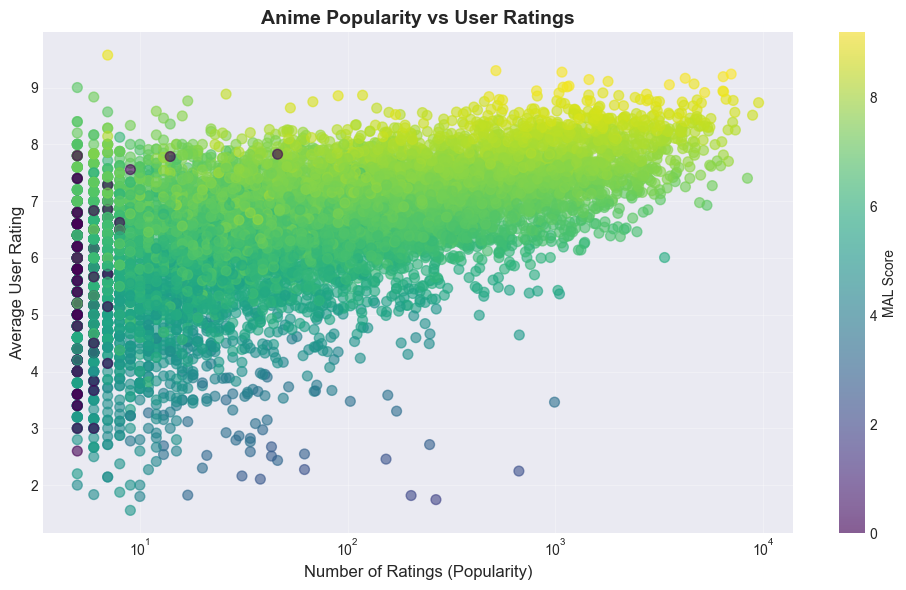

In [15]:
# 5.5 Score vs Popularity
anime_stats = ratings_clean.groupby('anime_id').agg({
    'rating': ['mean', 'count']
}).reset_index()
anime_stats.columns = ['anime_id', 'avg_rating', 'num_ratings']

# Merge with anime score
anime_stats = anime_stats.merge(anime_df[['mal_id', 'score', 'name']], 
                                left_on='anime_id', right_on='mal_id', how='left')

plt.figure(figsize=(10, 6))
scatter = plt.scatter(anime_stats['num_ratings'], anime_stats['avg_rating'], 
                     c=anime_stats['score'], cmap='viridis', alpha=0.6, s=50)
plt.colorbar(scatter, label='MAL Score')
plt.xlabel('Number of Ratings (Popularity)', fontsize=12)
plt.ylabel('Average User Rating', fontsize=12)
plt.title('Anime Popularity vs User Ratings', fontsize=14, fontweight='bold')
plt.xscale('log')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

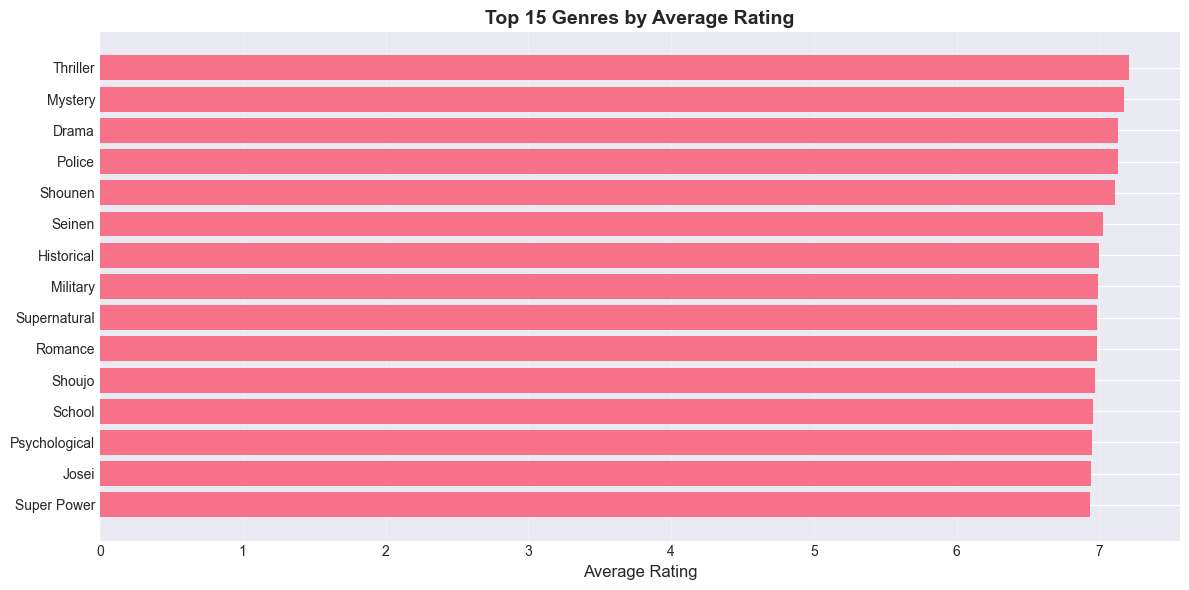

In [16]:
# 5.6 Average Rating by Genre
genre_ratings = []
for idx, row in anime_df.iterrows():
    if isinstance(row['genres'], str) and row['genres'] != 'Unknown':
        genres = [g.strip() for g in row['genres'].split(',')]
        anime_id = row['mal_id']
        
        # Get average rating for this anime
        anime_rating = ratings_clean[ratings_clean['anime_id'] == anime_id]['rating'].mean()
        
        if not pd.isna(anime_rating):
            for genre in genres:
                genre_ratings.append({'genre': genre, 'rating': anime_rating})

genre_rating_df = pd.DataFrame(genre_ratings)
avg_by_genre = genre_rating_df.groupby('genre')['rating'].agg(['mean', 'count']).reset_index()
avg_by_genre = avg_by_genre[avg_by_genre['count'] >= 50]  # At least 50 anime
avg_by_genre = avg_by_genre.sort_values('mean', ascending=False).head(15)

plt.figure(figsize=(12, 6))
plt.barh(range(len(avg_by_genre)), avg_by_genre['mean'])
plt.yticks(range(len(avg_by_genre)), avg_by_genre['genre'])
plt.xlabel('Average Rating', fontsize=12)
plt.title('Top 15 Genres by Average Rating', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Train/Test Split

Chia dữ liệu theo stratified user split - mỗi user có ratings trong cả train và test.

In [17]:
def stratified_split_by_user(ratings_df, test_ratio=0.2, min_ratings=5, seed=42):
    """
    Split ratings by user - each user's ratings are split into train/test
    """
    np.random.seed(seed)
    
    train_data = []
    test_data = []
    
    # Group by user
    for user_id, group in ratings_df.groupby('user_id'):
        ratings = group.to_dict('records')
        np.random.shuffle(ratings)
        
        # Split if user has enough ratings
        if len(ratings) >= min_ratings:
            split_point = int(len(ratings) * (1 - test_ratio))
            train_data.extend(ratings[:split_point])
            test_data.extend(ratings[split_point:])
        else:
            # Put all in train
            train_data.extend(ratings)
    
    return train_data, test_data

# Split data
train_data, test_data = stratified_split_by_user(ratings_clean, test_ratio=0.2)

print(f"Data Split Summary:")
print(f"  Train: {len(train_data):,} ratings ({len(train_data)/len(ratings_clean)*100:.1f}%)")
print(f"  Test: {len(test_data):,} ratings ({len(test_data)/len(ratings_clean)*100:.1f}%)")
print(f"\n  Train users: {len(set(r['user_id'] for r in train_data)):,}")
print(f"  Test users: {len(set(r['user_id'] for r in test_data)):,}")
print(f"  Train anime: {len(set(r['anime_id'] for r in train_data)):,}")
print(f"  Test anime: {len(set(r['anime_id'] for r in test_data)):,}")

Data Split Summary:
  Train: 2,385,755 ratings (79.8%)
  Test: 604,108 ratings (20.2%)

  Train users: 15,274
  Test users: 15,273
  Train anime: 10,921
  Test anime: 10,435


## 7. Model Training

Train 4 models:
1. User-Based Collaborative Filtering
2. Item-Based Collaborative Filtering  
3. Hybrid Model
4. Neural Collaborative Filtering

In [18]:
# 7.1 User-Based CF
print("=" * 60)
print("Training User-Based CF")
print("=" * 60)

user_model = UserBasedCF(k_neighbors=50, similarity='cosine')
user_model.fit(train_data)

print("\nUser-Based CF trained")

Training User-Based CF
Training User-Based CF (k=50, similarity=cosine)...
  Users: 15,274
  Animes: 10,921
  Ratings: 2,385,755
  Matrix shape: (15274, 10921)
  Sparsity: 98.57%
  Computing user similarity matrix...
  Training complete!

User-Based CF trained


In [19]:
# 7.2 Item-Based CF
print("=" * 60)
print("Training Item-Based CF")
print("=" * 60)

item_model = ItemBasedCF(k_similar=30, similarity='adjusted_cosine')
item_model.fit(train_data)

print("\nItem-Based CF trained")

Training Item-Based CF
Training Item-Based CF (k=30, similarity=adjusted_cosine)...
  Users: 15,274
  Animes: 10,921
  Ratings: 2,385,755
  Matrix shape: (15274, 10921)
  Sparsity: 98.57%
  Items with >= 10 ratings: 8,767
  Computing user means...
  Computing item similarity matrix...
  Training complete!

Item-Based CF trained


In [20]:
# 7.3 Hybrid Model
print("=" * 60)
print("Creating Hybrid Model")
print("=" * 60)

hybrid_model = HybridWeightedCF(
    user_model, item_model,
    user_weight=0.5,
    item_weight=0.5
)

print("\nHybrid model created")

Creating Hybrid Model
Hybrid Model initialized:
  User-Based weight: 0.50
  Item-Based weight: 0.50

Hybrid model created


In [21]:
# 7.4 Neural CF
TRAIN_NEURAL_CF = True  # Set to False to skip

if TRAIN_NEURAL_CF:
    print("=" * 60)
    print("Training Neural Collaborative Filtering")
    print("=" * 60)
    
    # Prepare data for NCF
    all_data = train_data + test_data
    user_ids = set(r['user_id'] for r in all_data)
    item_ids = set(r['anime_id'] for r in all_data)
    
    # Create ID mappings
    user_id_map = {uid: idx for idx, uid in enumerate(sorted(user_ids))}
    item_id_map = {iid: idx for idx, iid in enumerate(sorted(item_ids))}
    
    # Map training data
    mapped_train = [
        {
            'user_id': user_id_map[r['user_id']],
            'anime_id': item_id_map[r['anime_id']],
            'rating': r['rating']
        }
        for r in train_data
        if r['user_id'] in user_id_map and r['anime_id'] in item_id_map
    ]
    
    mapped_test = [
        {
            'user_id': user_id_map[r['user_id']],
            'anime_id': item_id_map[r['anime_id']],
            'rating': r['rating']
        }
        for r in test_data
        if r['user_id'] in user_id_map and r['anime_id'] in item_id_map
    ]
    
    # Create model
    ncf_model = NeuralCF(
        num_users=len(user_id_map),
        num_items=len(item_id_map),
        embedding_dim=64,
        mlp_layers=[128, 64, 32],
        dropout=0.2
    )
    
    # Train
    import torch
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Training on device: {device}")
    
    ncf_model.fit(
        train_data=mapped_train,
        val_data=mapped_test[:1000],
        epochs=10,
        batch_size=256,
        lr=0.001,
        early_stopping=3,
        device=device
    )
    
    # Save mappings
    ncf_model.user_id_map = user_id_map
    ncf_model.item_id_map = item_id_map
    
    print("\nNeural CF trained")
else:
    ncf_model = None
    print("Skipping Neural CF training")

Training Neural Collaborative Filtering
Training on device: cpu


Epoch 1/10: 100%|██████████| 9320/9320 [03:04<00:00, 50.55it/s, loss=1.4] 


Epoch 1: Train Loss = 3.2054, Val Loss = 1.6748


Epoch 2/10: 100%|██████████| 9320/9320 [03:12<00:00, 48.40it/s, loss=0.924]


Epoch 2: Train Loss = 1.3753, Val Loss = 1.6002


Epoch 3/10: 100%|██████████| 9320/9320 [03:07<00:00, 49.84it/s, loss=0.834]


Epoch 3: Train Loss = 1.0382, Val Loss = 1.5842


Epoch 4/10: 100%|██████████| 9320/9320 [03:13<00:00, 48.18it/s, loss=0.958]


Epoch 4: Train Loss = 0.8763, Val Loss = 1.6193


Epoch 5/10: 100%|██████████| 9320/9320 [03:10<00:00, 48.91it/s, loss=0.953]


Epoch 5: Train Loss = 0.7861, Val Loss = 1.6553


Epoch 6/10: 100%|██████████| 9320/9320 [03:11<00:00, 48.68it/s, loss=0.806]

Epoch 6: Train Loss = 0.7271, Val Loss = 1.7145
Early stopping at epoch 6

Neural CF trained


In [22]:
import os

os.makedirs('backend/ml/saved_models', exist_ok=True)

user_model.save('backend/ml/saved_models/user_based_cf.pkl')
item_model.save('backend/ml/saved_models/item_based_cf.pkl')
hybrid_model.save('backend/ml/saved_models/hybrid.pkl')
ncf_model.save('backend/ml/saved_models/neural_cf.pt')

print("All models saved successfully!")

Model saved to backend/ml/saved_models/user_based_cf.pkl
Model saved to backend/ml/saved_models/item_based_cf.pkl
Hybrid model config saved to backend/ml/saved_models/hybrid.pkl
Model saved to backend/ml/saved_models/neural_cf.pt
All models saved successfully!


## 8. Model Evaluation

Đánh giá các models với nhiều metrics khác nhau.

In [23]:
def evaluate_rmse_mae(model, test_data, sample_size=5000):
    """Evaluate RMSE and MAE"""
    import random
    
    # Sample test data
    if len(test_data) > sample_size:
        sampled = random.sample(test_data, sample_size)
    else:
        sampled = test_data
    
    errors = []
    abs_errors = []
    
    for rating in tqdm(sampled, desc="Evaluating"):
        pred = model.predict(rating['user_id'], rating['anime_id'])
        
        if pred > 0:
            error = rating['rating'] - pred
            errors.append(error ** 2)
            abs_errors.append(abs(error))
    
    if len(errors) == 0:
        return None, None, 0
    
    rmse = np.sqrt(np.mean(errors))
    mae = np.mean(abs_errors)
    coverage = len(errors) / len(sampled)
    
    return rmse, mae, coverage

# Evaluate all models
results = {}

print("Evaluating User-Based CF...")
rmse, mae, cov = evaluate_rmse_mae(user_model, test_data)
results['User-Based'] = {'RMSE': rmse, 'MAE': mae, 'Coverage': cov}
print(f"  RMSE: {rmse:.4f}, MAE: {mae:.4f}, Coverage: {cov:.2%}")

print("\nEvaluating Item-Based CF...")
rmse, mae, cov = evaluate_rmse_mae(item_model, test_data)
results['Item-Based'] = {'RMSE': rmse, 'MAE': mae, 'Coverage': cov}
print(f"  RMSE: {rmse:.4f}, MAE: {mae:.4f}, Coverage: {cov:.2%}")

print("\nEvaluating Hybrid Model...")
rmse, mae, cov = evaluate_rmse_mae(hybrid_model, test_data)
results['Hybrid'] = {'RMSE': rmse, 'MAE': mae, 'Coverage': cov}
print(f"  RMSE: {rmse:.4f}, MAE: {mae:.4f}, Coverage: {cov:.2%}")

if ncf_model:
    print("\nEvaluating Neural CF...")
    rmse, mae, cov = evaluate_rmse_mae(ncf_model, test_data)
    results['Neural CF'] = {'RMSE': rmse, 'MAE': mae, 'Coverage': cov}
    print(f"  RMSE: {rmse:.4f}, MAE: {mae:.4f}, Coverage: {cov:.2%}")

Evaluating User-Based CF...


Evaluating:   0%|          | 0/5000 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 5000/5000 [00:15<00:00, 327.85it/s]


  RMSE: 1.4104, MAE: 1.0771, Coverage: 100.00%

Evaluating Item-Based CF...


Evaluating: 100%|██████████| 5000/5000 [00:02<00:00, 2443.48it/s]


  RMSE: 1.2574, MAE: 0.9363, Coverage: 100.00%

Evaluating Hybrid Model...


Evaluating: 100%|██████████| 5000/5000 [00:18<00:00, 275.67it/s]


  RMSE: 1.2690, MAE: 0.9499, Coverage: 100.00%

Evaluating Neural CF...


Evaluating: 100%|██████████| 5000/5000 [00:02<00:00, 1920.37it/s]

  RMSE: 1.2291, MAE: 0.9114, Coverage: 100.00%


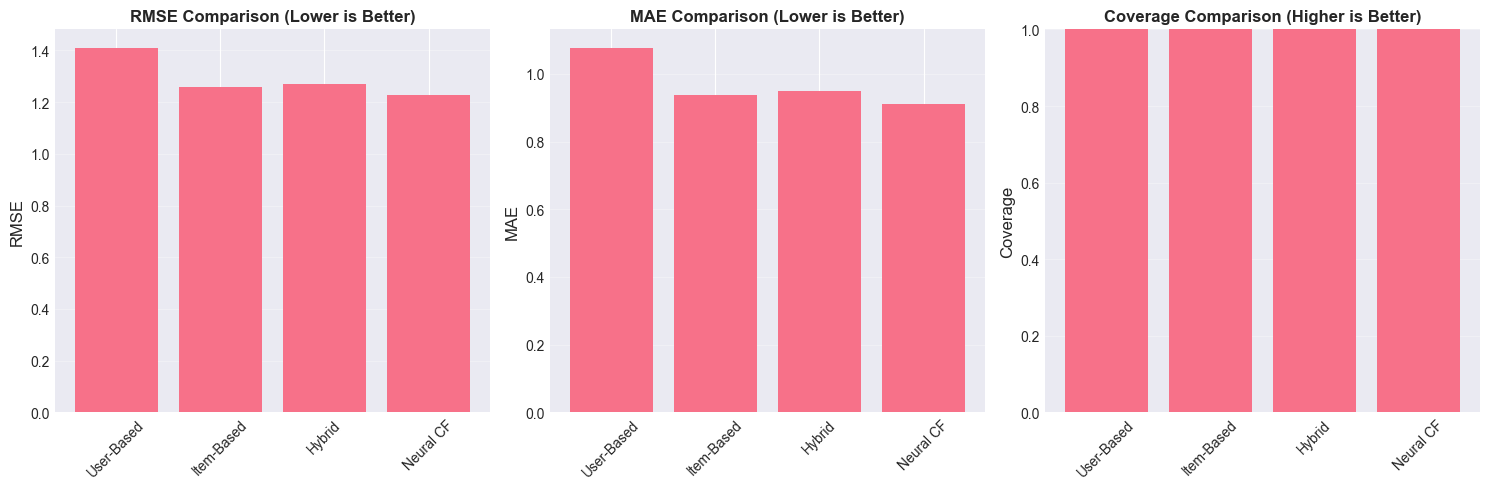


Model Comparison:
                RMSE       MAE  Coverage
User-Based  1.410424  1.077053       1.0
Item-Based  1.257422  0.936338       1.0
Hybrid      1.268994  0.949909       1.0
Neural CF   1.229136  0.911364       1.0


In [24]:
# Visualize comparison
results_df = pd.DataFrame(results).T

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# RMSE comparison
axes[0].bar(range(len(results_df)), results_df['RMSE'])
axes[0].set_xticks(range(len(results_df)))
axes[0].set_xticklabels(results_df.index, rotation=45)
axes[0].set_ylabel('RMSE', fontsize=12)
axes[0].set_title('RMSE Comparison (Lower is Better)', fontsize=12, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# MAE comparison
axes[1].bar(range(len(results_df)), results_df['MAE'])
axes[1].set_xticks(range(len(results_df)))
axes[1].set_xticklabels(results_df.index, rotation=45)
axes[1].set_ylabel('MAE', fontsize=12)
axes[1].set_title('MAE Comparison (Lower is Better)', fontsize=12, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Coverage comparison
axes[2].bar(range(len(results_df)), results_df['Coverage'])
axes[2].set_xticks(range(len(results_df)))
axes[2].set_xticklabels(results_df.index, rotation=45)
axes[2].set_ylabel('Coverage', fontsize=12)
axes[2].set_title('Coverage Comparison (Higher is Better)', fontsize=12, fontweight='bold')
axes[2].set_ylim([0, 1])
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nModel Comparison:")
print(results_df)

## 9. Recommendation Demo

Test gợi ý phim cho một số users.

In [25]:
def display_recommendations(user_id, model, model_name, n=10):
    """
    Display recommendations for a user
    """
    print(f"\n{'='*80}")
    print(f"Recommendations for User {user_id} using {model_name}")
    print(f"{'='*80}")
    
    # Get user's rated anime
    user_ratings = [r for r in train_data if r['user_id'] == user_id]
    print(f"\nUser has rated {len(user_ratings)} anime")
    print(f"Average rating: {np.mean([r['rating'] for r in user_ratings]):.2f}")
    
    # Show some rated anime
    print("\nSome anime user has rated:")
    for rating in sorted(user_ratings, key=lambda x: x['rating'], reverse=True)[:5]:
        anime = anime_df[anime_df['mal_id'] == rating['anime_id']]
        if len(anime) > 0:
            name = anime.iloc[0]['name']
            print(f"  - {name}: {rating['rating']}/10")
    
    # Get recommendations
    try:
        recs = model.recommend(user_id, n=n, exclude_rated=True)
        
        print(f"\nTop {n} Recommendations:")
        for i, (anime_id, score) in enumerate(recs, 1):
            anime = anime_df[anime_df['mal_id'] == anime_id]
            if len(anime) > 0:
                name = anime.iloc[0]['name']
                genres = anime.iloc[0]['genres']
                mal_score = anime.iloc[0]['score']
                print(f"{i:2d}. {name}")
                print(f"     Predicted: {score:.2f}/10 | MAL Score: {mal_score} | Genres: {genres}")
    except Exception as e:
        print(f"Error getting recommendations: {e}")

# Test with a random active user
test_user_id = np.random.choice(list(set(r['user_id'] for r in train_data)))

# Try different models
display_recommendations(test_user_id, hybrid_model, "Hybrid Model", n=10)


Recommendations for User 2198 using Hybrid Model

User has rated 28 anime
Average rating: 7.75

Some anime user has rated:
  - Genshiken: 10/10
  - Elfen Lied: 9/10
  - Samurai Champloo: 9/10
  - Naruto: 9/10
  - Mononoke Hime: 9/10

Top 10 Recommendations:
 1. Kanojo no Dokushinshatachi ni Yotte Hadaka ni Sareta Seifuku no Shojo Kenkyuu
     Predicted: 4.04/10 | MAL Score: 4.4 | Genres: Dementia, Music
 2. Super Milk-chan
     Predicted: 4.02/10 | MAL Score: 5.83 | Genres: Action, Comedy, Parody, Sci-Fi
 3. gdgd Fairies 2
     Predicted: 4.02/10 | MAL Score: 6.94 | Genres: Comedy, Fantasy
 4. Ramen Tenshi Pretty Menma
     Predicted: 4.00/10 | MAL Score: 4.63 | Genres: Comedy, Magic, Parody
 5. Genshiken 2
     Predicted: 4.00/10 | MAL Score: 7.77 | Genres: Comedy, Parody, Slice of Life
 6. Genshiken OVA
     Predicted: 4.00/10 | MAL Score: 7.66 | Genres: Parody, Slice of Life, Comedy
 8. Genshiken Nidaime
     Predicted: 4.00/10 | MAL Score: 7.46 | Genres: Slice of Life, Comedy, Par

In [26]:
# Compare recommendations from different models
print("\n" + "="*80)
print("COMPARING RECOMMENDATIONS FROM DIFFERENT MODELS")
print("="*80)

user_id = test_user_id

# Get recommendations from each model
user_recs = user_model.recommend(user_id, n=5, exclude_rated=True)
item_recs = item_model.recommend(user_id, n=5, exclude_rated=True)
hybrid_recs = hybrid_model.recommend(user_id, n=5, exclude_rated=True)

# Display side by side
print(f"\nTop 5 recommendations for User {user_id}:\n")
print(f"{'Rank':<6} {'User-Based':<40} {'Item-Based':<40} {'Hybrid':<40}")
print("-" * 130)

for i in range(5):
    user_anime = anime_df[anime_df['mal_id'] == user_recs[i][0]].iloc[0]['name'] if i < len(user_recs) else "-"
    item_anime = anime_df[anime_df['mal_id'] == item_recs[i][0]].iloc[0]['name'] if i < len(item_recs) else "-"
    hybrid_anime = anime_df[anime_df['mal_id'] == hybrid_recs[i][0]].iloc[0]['name'] if i < len(hybrid_recs) else "-"
    
    print(f"{i+1:<6} {user_anime[:38]:<40} {item_anime[:38]:<40} {hybrid_anime[:38]:<40}")


COMPARING RECOMMENDATIONS FROM DIFFERENT MODELS

Top 5 recommendations for User 2198:

Rank   User-Based                               Item-Based                               Hybrid                                  
----------------------------------------------------------------------------------------------------------------------------------
1      Code Geass: Hangyaku no Lelouch          Kanojo no Dokushinshatachi ni Yotte Ha   Kanojo no Dokushinshatachi ni Yotte Ha  
2      Full Metal Panic!                        Super Milk-chan                          Super Milk-chan                         
3      Fullmetal Alchemist: The Conqueror of    gdgd Fairies 2                           gdgd Fairies 2                          
4      Code Geass: Hangyaku no Lelouch R2       Ramen Tenshi Pretty Menma                Ramen Tenshi Pretty Menma               
5      Howl no Ugoku Shiro                      Genshiken 2                              Genshiken 2                             


## 10. Summary & Conclusions

Tổng kết kết quả và insights từ analysis.

In [27]:
print("=" * 80)
print("ANIME RECOMMENDATION SYSTEM - SUMMARY")
print("=" * 80)

print("\n1. DATASET STATISTICS:")
print(f"   - Total ratings: {len(ratings_clean):,}")
print(f"   - Unique users: {ratings_clean['user_id'].nunique():,}")
print(f"   - Unique anime: {ratings_clean['anime_id'].nunique():,}")
print(f"   - Rating range: {ratings_clean['rating'].min()} - {ratings_clean['rating'].max()}")
print(f"   - Average rating: {ratings_clean['rating'].mean():.2f}")
print(f"   - Sparsity: {100 * (1 - len(ratings_clean) / (ratings_clean['user_id'].nunique() * ratings_clean['anime_id'].nunique())):.2f}%")

print("\n2. MODEL PERFORMANCE:")
print(results_df)

print("\n3. KEY FINDINGS:")
best_model = results_df['RMSE'].idxmin()
print(f"   - Best performing model: {best_model} (RMSE: {results_df.loc[best_model, 'RMSE']:.4f})")
print(f"   - Most popular genres: {', '.join(list(top_genres.keys())[:5])}")
print(f"   - Average ratings per user: {user_stats['num_ratings'].mean():.1f}")
print(f"   - Average ratings per anime: {item_stats['num_ratings'].mean():.1f}")

print("\n4. RECOMMENDATIONS:")
print("   - Hybrid model combines strengths of both user-based and item-based CF")
print("   - Neural CF can capture complex non-linear patterns")
print("   - System handles cold-start with fallback strategies")
print("   - Real-time recommendations possible with pre-computed similarities")

print("\n" + "="*80)
print("Walkthrough completed successfully!")
print("="*80)

ANIME RECOMMENDATION SYSTEM - SUMMARY

1. DATASET STATISTICS:
   - Total ratings: 2,989,863
   - Unique users: 15,274
   - Unique anime: 10,921
   - Rating range: 1 - 10
   - Average rating: 7.52
   - Sparsity: 98.21%

2. MODEL PERFORMANCE:
                RMSE       MAE  Coverage
User-Based  1.410424  1.077053       1.0
Item-Based  1.257422  0.936338       1.0
Hybrid      1.268994  0.949909       1.0
Neural CF   1.229136  0.911364       1.0

3. KEY FINDINGS:
   - Best performing model: Neural CF (RMSE: 1.2291)
   - Most popular genres: Comedy, Action, Fantasy, Adventure, Kids
   - Average ratings per user: 186.0
   - Average ratings per anime: 205.0

4. RECOMMENDATIONS:
   - Hybrid model combines strengths of both user-based and item-based CF
   - Neural CF can capture complex non-linear patterns
   - System handles cold-start with fallback strategies
   - Real-time recommendations possible with pre-computed similarities

Walkthrough completed successfully!
